In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

# data_preprocessing

In [2]:
base_dir = r'D:\dataset\dental\data'

In [2]:
data = np.load(base_dir + '\\data_KNU_Diorco_so_imgs.npy')
label_csv= open(base_dir + '\\data_KNU_Diorco_so_img_labels.csv', 'r')
label = csv.reader(label_csv)

right_label = np.load(base_dir + '\\right_label.npy')
left_label = np.load(base_dir + '\\left_label.npy')

right = data[:,:,:, 0:3]
left = data[:,:,:, 3:7]

patient_data = []
patient_data.extend(left)
patient_data.extend(right)
patient_data = np.array(patient_data)

patient_labels = []
patient_labels.extend(left_label)
patient_labels.extend(right_label)
patient_labels = np.array(patient_labels)

train_data, test_data, train_label, test_label= train_test_split(patient_data, patient_labels, test_size = 0.2, random_state = 33, shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 33, shuffle = True)

train_data = train_data.astype(np.float32) / 127.5 - 1
test_data = test_data.astype(np.float32) / 127.5 - 1
val_data = val_data.astype(np.float32) / 127.5 - 1

In [3]:
model = models.load_model('real5_dental_ResNet50V2_clf.h5')
model.load_weights('real5_dental_ResNet50V2_clf.h5')

In [5]:
x = np.load(base_dir + '\\temp_data.npy')

In [9]:
x = np.expand_dims(x, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


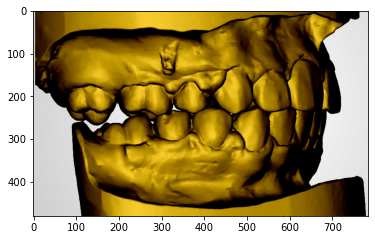

In [6]:
plt.imshow(x[0])

In [16]:
preds = model.predict(x)

In [18]:
del preds

In [6]:
last_conv_layer_name = 'conv5_block3_3_conv'
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_1",
    "dense_2"
]

In [7]:
normal_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv5_block3_3_conv')
grads = K.gradients(normal_output, last_conv_layer.output)[0]

In [10]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(len(pooled_grads_value)-1):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

In [9]:
# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([last_conv_layer.output], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate(x)

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(len(pooled_grads_value)-1):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

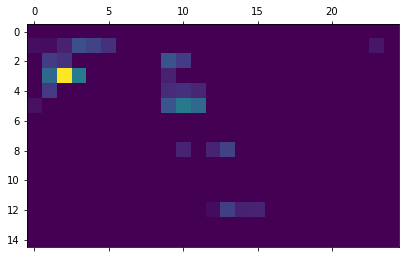

In [11]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)